In [ ]:
!python --version

Python 3.7.15


In [3]:
!pip install cvrplib alns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 1.1 MB/s 
     |████████████████████████████████| 62 kB 504 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
import collections
import copy
import itertools

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import numpy.random as rnd
import cvrplib

from alns import ALNS, State
from alns.accept import SimulatedAnnealing, RecordToRecordTravel, HillClimbing
from alns.stop import MaxRuntime, MaxIterations
from alns.weights import SimpleWeights

In [5]:
%matplotlib inline

In [6]:
SEED = 1234
rnd_state = rnd.RandomState(SEED)

# Capacitated Vehicle Routing Problem
The vehicle routing problem (VRP) is one of the most studied problems in operations research. Given a fleet of vehicles and customers, the goal of VRP is to construct a set of routes such that each customer is visited exactly once, while minimizing the total distance traveled by the vehicles. 

Despite the decades long research, the VRP (and variants thereof) remains a very hard problem to solve and new algorithms continue to be developed to tackle this problem. For example, ALNS was originally proposed by [Ropke and Pisinger](https://pubsonline.informs.org/doi/abs/10.1287/trsc.1050.0135?casa_token=-DeLGU-Nr_4AAAAA:hTPxhhAn8TRi5h8p5LdQ_r-tQ1j4lCD4-K4ZR4gSi0e9O6reL6vcyfC0NZmkW1hoQGkUEjcumwH6) to solve many variants of the vehicle routing problem. 

In this notebook, we use ALNS to solve the most famous VRP variant: the *Capacitated Vehicle Routing Problem (CVRP)*. The CVRP can be described using an undirected graph $G=(V,E)$, where $V$ is the vertex set and $E$ is the edge set. The vertex set $V$ is partitioned into $V=\{0\} \cup V_c$, where $0$ is the depot and $V_c=\{1, \dots, n\}$ denotes the set of $n$ customers. Each customer $i \in V_c$ has a demand $q_i > 0$. A distance $d_{ij}$ is associated with each edge $(i, j) \in E$. We assume that we have an unlimited fleet of homogeneous vehicles with capacity $Q$ located at the depot. A feasible solution to the CVRP is a set of routes, each served by a single vehicle, such that each customer is served exactly once and none of the routes exceed the vehicle capacity. The goal is to minimize the total distance traveled.

## Data
[CVRPLIB](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/) contains a large collection of CVRP benchmark instances. The library is actively maintained and new best known solutions are updated regularly. We will make use of the `cvrplib` package to download the `D/ORTEC-n242-k12` instance, which consists of 241 customers (+ 1 depot) and 12 vehicles.

In [7]:
data, bks = cvrplib.download('ORTEC-n242-k12', solution=True)

The `bks` variable contains the best known solution. Let's plot it, together with the coordinates of the customers:

In [16]:
def plot_solution(solution, name="CVRP solution"):
    """
    Plot the routes of the passed-in solution.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = matplotlib.cm.rainbow(np.linspace(0, 1, len(solution.routes)))

    for idx, route in enumerate(solution.routes):
        ax.plot(
            [data.coordinates[loc][0] for loc in [0] + route + [0]],
            [data.coordinates[loc][1] for loc in [0] + route + [0]],
            color=cmap[idx],
            marker='.',
        )

    ax.set_title(f"{name}\n Total distance: {solution.cost}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")




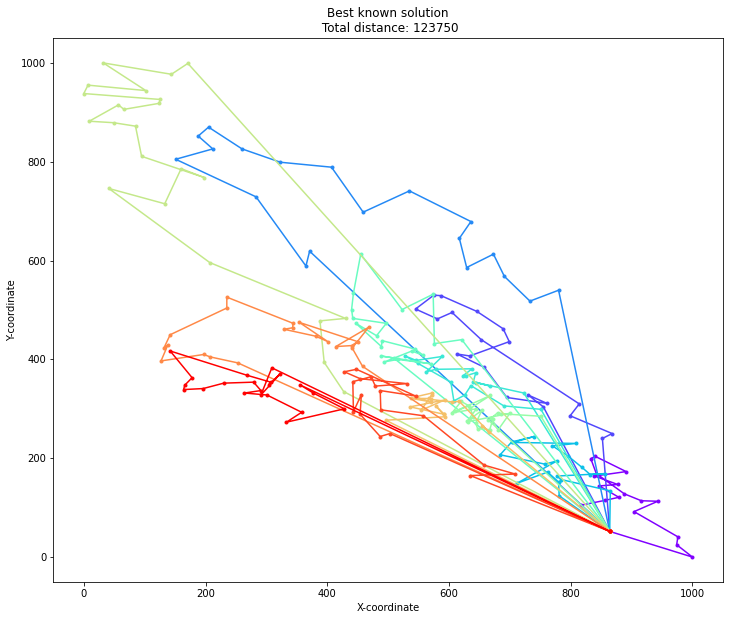

In [17]:
plot_solution(bks, name="Best known solution")

## Solution state and operators
To use the ALNS meta-heuristic, we need to have destroy and repair operators that work on a proposed solution, and a way to describe such a solution in the first place. The ALNS package exposes the class `State` to describe a solution, with an `objective()` member that computes this solution's objective value. Using it, we may compute a simple initial solution, and then apply the ALNS algorithm.

## Solution state

In [18]:
class CvrpState(State):
    """
    Solution state for CVRP. It has two data members, routes and unassigned.
    Routes is a list of list of integers, where each inner list corresponds to
    a single route denoting the sequence of customers to be visited. A route
    does not contain the start and end depot. Unassigned is a list of integers, 
    each integer representing an unassigned customer.
    """

    def __init__(self, routes, unassigned=None):
        self.routes = routes
        self.unassigned = unassigned if unassigned is not None else []

    def copy(self):
        """
        Helper method to ensure each solution state is immutable.
        """
        return CvrpState(copy.deepcopy(self.routes),
                        self.unassigned.copy())

    def objective(self):
        """
        Computes the total route costs.
        """
        return sum(route_cost(route) for route in self.routes)
    
    @property
    def cost(self):
        """
        Alias for objective method.
        """
        return self.objective()

    def plot(self, name):
        """
        Helper method to plot a solution.
        """
        plot_solution(self, name=name)

    def find_route(self, customer):
        """
        Return the route that contains the passed-in customer.
        """
        for route in self.routes:
            if customer in route:
                return route

        raise ValueError(f"Solution does not contain customer {customer}.")
        
def route_cost(route):
    tour = [0] + route + [0]
    return sum(data.distances[tour[idx]][tour[idx+1]] for idx in range(len(tour) - 1))

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [ ]:
degree_of_destruction = 0.05
customers_to_remove = int((data.dimension - 1) * degree_of_destruction)

In [ ]:
def random_removal(state, rnd_state):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = state.copy()

    for customer in rnd_state.choice(range(1, data.dimension), customers_to_remove, replace=False):
        destroyed.unassigned.append(customer)

        for route in destroyed.routes:
            if customer in route:
                route.remove(customer)
                break

    return remove_empty_routes(destroyed)


def remove_empty_routes(state):
    """
    Remove empty routes after applying the destroy operator.
    """
    state.routes = [route for route in state.routes if len(route) != 0]
    return state

## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost.

In [ ]:
def greedy_repair(state, rnd_state):
    """
    Inserts the unassigned customers in the best route.
    If there are no feasible insertions, then create a new route.
    """
    rnd_state.shuffle(state.unassigned)
    
    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)
        
        if route is not None:
            route.insert(idx, customer)
        else:
            state.routes.append([customer])

    return state


def best_insert(customer, state):
    """
    Finds the best feasible route and insertion idx for the customer.
    """
    best_cost, best_route, best_idx = None, None, None
    
    for route in state.routes:
        for idx in range(len(route) + 1):

            if can_insert(customer, route):
                cost = insert_cost(customer, route, idx)
            
                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx
                
    return best_route, best_idx


def can_insert(customer, route):
    """
    Checks if a customer can be inserted in the route w.r.t. the capacity constraints.
    """
    return sum(data.demands[cust] for cust in route) + data.demands[customer] <= data.capacity


def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at idx.
    """
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]

    # Increase in cost by adding the customer
    cost = data.distances[pred][customer] + data.distances[customer][succ]
    
    # Decrease in cost by removing old edge (pred, succ)
    cost -= data.distances[pred][succ]

    return cost

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

In [ ]:
def neighbors(customer):
    """Return the nearest neighbors of the customer, excluding the depot."""
    locations = np.argsort(data.distances[customer])
    return locations[locations != 0]

def nearest_neighbor():
    """
    Build a solution by iteratively constructing routes, where the nearest
    customer is added until the route has met the vehicle capacity limit.
    """
    routes = []
    unvisited = list(range(1, data.dimension))

    while unvisited:
        route = [0] # Start at the depot
        route_demands = 0

        while unvisited:
            # Add the nearest unvisited customer to the route until the truck is full
            current = route[-1]
            nearest = [nb for nb in neighbors(current) if nb in unvisited][0]
            
            if route_demands + data.demands[nearest] > data.capacity:
                break

            route.append(nearest)
            unvisited.remove(nearest)
            route_demands += data.demands[nearest]

        customers = route[1:] # Remove the depot
        routes.append(customers)

    return CvrpState(routes)


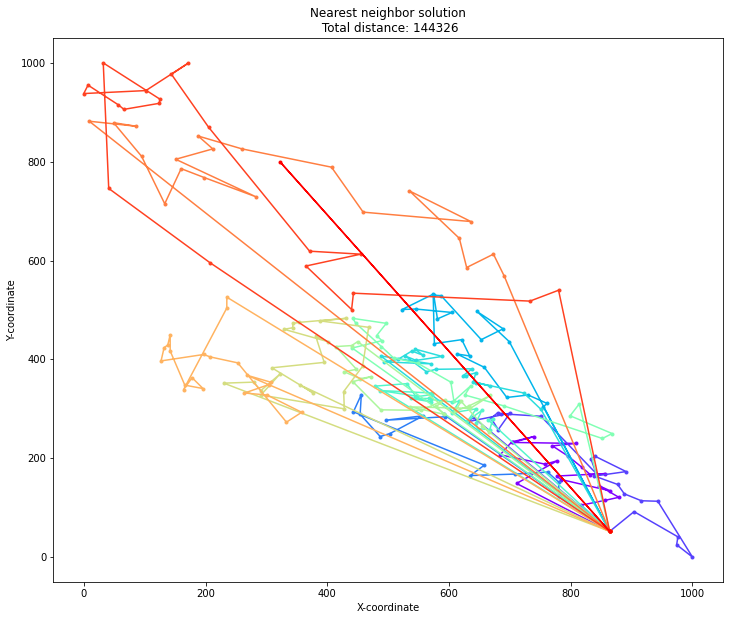

In [ ]:
initial = nearest_neighbor()
initial.plot('Nearest neighbor solution')

## Heuristic solution
Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we actually don't use the adaptive part (i.e., operator selection), but you can easily add more destroy/repair operators. 

In [ ]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair)

In [ ]:
criterion = criterion = SimulatedAnnealing.autofit(initial.cost, worse=0.025, accept_prob=0.50, num_iters=4000)
weights = SimpleWeights([3, 2, 1, 0.5], 1, 1, 0.8)
stop = MaxRuntime(60)

result = alns.iterate(initial, weights, criterion, stop)

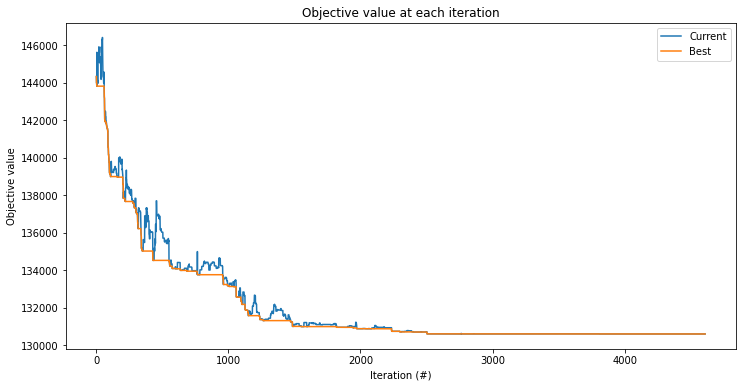

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

Best heuristic objective is 130601.
This is 5.5% worse than the optimal solution, which is 123750.


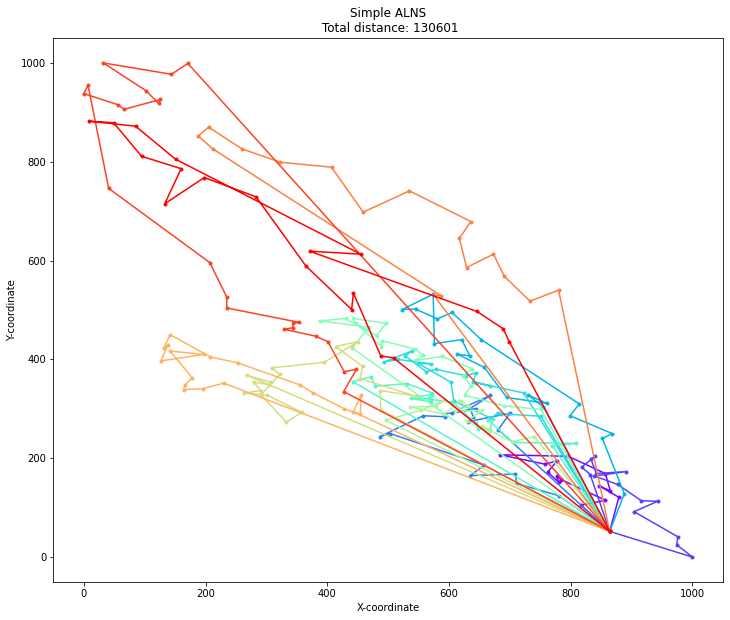

In [ ]:
solution = result.best_state
objective = solution.objective()
pct_difference = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {bks.cost}.")
solution.plot('Simple ALNS')


With only a random destroy and greedy repair operator, we have managed to find a solution that is ?? worse than the best known solution!

## Slack-induced substring removal
The simple destroy and repair operator from earlier are fairly effective, but there are better destroy and repair operators for CVRP. The so-called *Slack Induction by Substring Removal (SISR)* method proposed by [2] obtains state-of-the-art results using only one destroy and repair operator. Instead of removing random customers, SISR removes partial routes (called *[sub]strings*) that are all located near eachother. Moreover, a blinking feature is added to the greedy repair operator, where certain insertion checks are skipped. For more details, we refer to [1].

In [ ]:
# Algorithm parameters
NUM_DESTRUCTION = 10  # Average number of customers to be removed per iteration
MAX_CARDINALITY = 10  # L^\max: the maximum cardinality of the removed strings
SPLIT_RATE = 0.5  # alpha
SPLIT_DEPTH = 0.5  # beta
BLINK_RATE = 0.01  # gamma


def string_removal(state, rnd_state):
    """
    Destroy operator of the Slack Induction by String Removal method by [1].
    Strings, i.e., partial routes, are iteratively removed from the solution
    around a randomly chosen customer.

    References
    ----------
    [1] Christiaens, J., & Vanden Berghe, G. (2020). Slack induction by string
    removals for vehicle routing problems. Transportation Science, 54(2), 417-433.
    """
    destroyed = state.copy()

    max_str_card = max_string_cardinality(destroyed)
    max_destroyed_routes = n_strings_to_remove(max_str_card, rnd_state)
    destroyed_routes = []
    center = rnd_state.randint(1, data.dimension)

    for customer in neighbors(center):

        if len(destroyed_routes) >= max_destroyed_routes:
            break 

        if customer in destroyed.unassigned:
            continue

        route = destroyed.find_route(customer)
        if route in destroyed_routes:
            continue

        destroyed_custs = remove_string(route, customer, max_str_card, rnd_state)

        destroyed.unassigned.extend(destroyed_custs)
        destroyed_routes.append(route)

    return destroyed


def max_string_cardinality(state):
    """
    Compute the maximum cardinality of strings to be removed.

    Eq. (5) in [1].
    """
    avg_card = int(np.mean([len(route) for route in state.routes]))
    return min(MAX_CARDINALITY, avg_card)


def n_strings_to_remove(max_string_card, rnd_state):
    """
    Compute the number of strings to remove.

    Eq. (6) and (7) in [1].
    """
    max_n_strings_to_remove = (4 * NUM_DESTRUCTION) / (1 + max_string_card) - 1
    return rnd_state.randint(1, max_n_strings_to_remove + 1)


def string_cardinality(route, max_card, rnd_state):
    """
    Compute the cardinality of the string to be removed from the route.

    Eq. (8) and (9) in [1].
    """
    return rnd_state.randint(1, min(len(route), max_card) + 1)


def remove_string(route, cust, max_string_card, rnd_state):
    """
    Remove a string from the passed-in route using either the `string` procedure
    or the `split-string` procedure. Procedure is selected randomly based on
    `SPLIT_RATE`.

    `removeSelected` in [1].
    """
    card = string_cardinality(route, max_string_card, rnd_state)

    # "String" removal procedure
    if rnd_state.random() <= SPLIT_RATE:
        rem_idcs = select_string(route, cust, card, rnd_state)

    # "Split-string" removal procedure
    else:
        substr_len = 1
        while rnd_state.random() > SPLIT_DEPTH and substr_len < len(route) - card:
            substr_len += 1

        str_idcs = select_string(route, cust, card + substr_len, rnd_state)

        # Remove a substring of length m from the string
        start = rnd_state.randint(len(str_idcs) - substr_len)
        rem_idcs = str_idcs[:start] + str_idcs[start + substr_len :]

    rem_custs = [cust for idx, cust in enumerate(route) if idx in rem_idcs]

    for cust in rem_custs:
        route.remove(cust)

    return rem_custs


def select_string(route, customer, cardinality, rnd_state):
    """
    Return the route indices of a randomly selected string of length
    cardinality, containing the passed-in customer.
    """
    route_idx = route.index(customer)
    customer_pos = rnd_state.randint(cardinality)
    start = route_idx - customer_pos
    string_indices = [idx % len(route) for idx in range(start, start + cardinality)]
    return string_indices


###########################


def greedy_repair_with_blinks(state, rnd_state):
    """
    Greedily insert the unassigned customers back with blinking [1].
    """
    _sort_sisr(state, rnd_state)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = blink_insert(state, customer, rnd_state)

        if route is not None:
            route.insert(idx, customer)
        else:
            state.routes.append([customer])

    return state


def _sort_sisr(state, rnd_state):
    """
    Sort the unassigned customers in-place based on different proprties.
    """
    order = rnd_state.choice(
        ["random", "demand", "far", "close"], p=[4 / 11, 4 / 11, 2 / 11, 1 / 11]
    )

    if order == "random":
        rnd_state.shuffle(state.unassigned)

    elif order == "demand":
        state.unassigned.sort(key=lambda cust: -data.demands[cust])

    elif order == "far":
        state.unassigned.sort(key=lambda cust: -data.distances[0][cust])

    elif order == "close":
        state.unassigned.sort(key=lambda cust: data.distances[0][cust])


def blink_insert(state, customer, rnd_state):
    """
    Return the best route and best insertion index. All insertion points are
    enumerated over, but some insertion checks are skipped with probability
    `BLINK_RATE`.
    """
    best_cost, best_route, best_idx = None, None, None

    for route in state.routes:
        if can_insert(customer, route):
            for idx in range(len(route) + 1):
                if rnd_state.random() > BLINK_RATE:
                    cost = insert_cost(customer, route, idx)

                    if best_cost is None or cost < best_cost:
                        best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


In [ ]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(string_removal)

alns.add_repair_operator(greedy_repair_with_blinks)

In [ ]:
initial = nearest_neighbor()
ITERS = 2000
criterion = RecordToRecordTravel.autofit(initial.cost, start_gap=0.01, end_gap=0, num_iters=ITERS)
weights = SimpleWeights([3, 2, 1, 0.5], 1, 1, 0.8)
stop = MaxIterations(ITERS)

result = alns.iterate(initial, weights, criterion, stop)

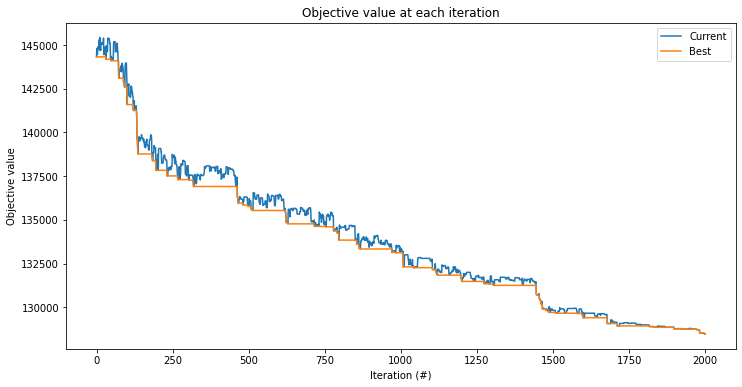

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

Best heuristic objective is 128480.
This is 3.8% worse than the optimal solution, which is 123750.


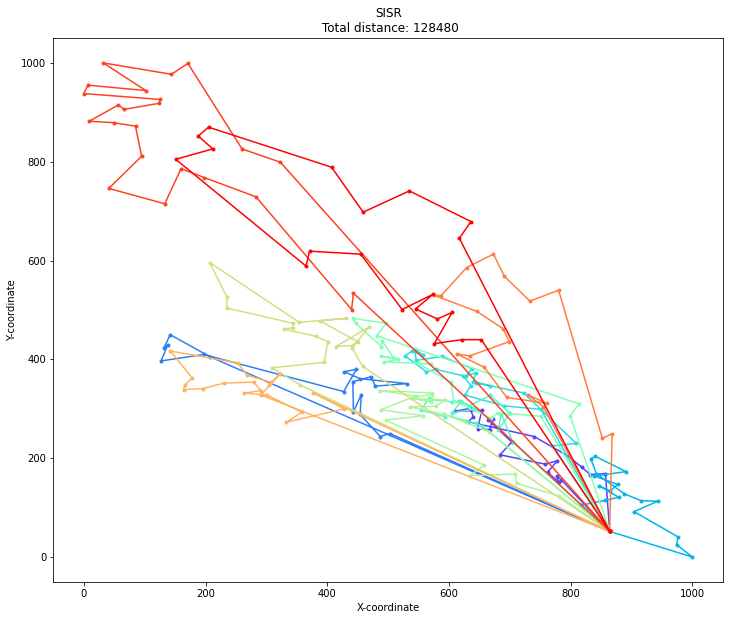

In [ ]:
solution = result.best_state
objective = solution.objective()
pct_difference = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
print(f"This is {pct_difference:.1f}% worse than the optimal solution, which is {bks.cost}.")
solution.plot('SISR')